In [ ]:
"""
Hunter Mitchell
09/16/20
Mechanisms of Action (MoA) Kaggle Competition
"""

## Intro

This kernel serves as a stratified k-fold ensemble approach baseline for the MoA (Mechanisms of Action) kaggle competition. The 3 models I have seen mostly used for this competition are Neural Networks, XGBoost (or some other boosted tree model), and Logistic Regression. Here I present a simple starter notebook to ensemble these three models with cross validation.

There are many ways to improve the validation and leaderboard score from this notebook. Here are some ideas to experiment with:
* Principal Component Analysis
* Grid search to optimize model hyperparameters
* Experimenting with number of epochs, number of layers, types of layers, learning rate, etc. for Neural Network
* Bagging/boosting with other models

## Getting everything ready

We will be using a multi-label stratified K-fold. Scikit-learn doesn't support this, but there is one located in this GitHub repository: [https://github.com/trent-b/iterative-stratification](http://) . We would normally be able to install this package with a simple pip command, but the competition rules state no internet use is allowed. Therefore, we will have to manually add this to our input.

In [87]:
### Importing necessary libraries

import sys
sys.path.append('/kaggle/input/iterativestratification') # Multilabel Stratified K-Fold package

from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

import numpy as np 
import pandas as pd 

import tensorflow as tf
import tensorflow.keras.layers as L

from xgboost import XGBClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import log_loss

import time

import category_encoders as ce

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

In [89]:
### Settings

SEED = 2020 
FOLDS = 4
EPOCHS = 25
BATCH_SIZE = 128


# Which models to use
include_xgboost = True
include_neural_net = True
include_logreg = False


lr_start=0.0001
lr_max=0.0003
lr_min=0.00001
lr_rampup_epochs=5
lr_sustain_epochs=2
lr_exp_decay=.7

In [90]:
### Creating dataframes

TEST_FEATURES_PATH = "/kaggle/input/lish-moa/test_features.csv"
TRAIN_FEATURES_PATH = "/kaggle/input/lish-moa/train_features.csv"
TRAIN_TARGETS_PATH = "/kaggle/input/lish-moa/train_targets_scored.csv"
TRAIN_TARGETS_NONSCORED_PATH = "/kaggle/input/lish-moa/train_targets_nonscored.csv"
SAMPLE_SUB_PATH = "/kaggle/input/lish-moa/sample_submission.csv"

test_features_df = pd.read_csv(TEST_FEATURES_PATH).sort_values(by='sig_id')
train_features_df = pd.read_csv(TRAIN_FEATURES_PATH).sort_values(by='sig_id')
train_targets_df = pd.read_csv(TRAIN_TARGETS_PATH).sort_values(by='sig_id')
train_targets_nonscored_df = pd.read_csv(TRAIN_TARGETS_NONSCORED_PATH)
sample_sub_df = pd.read_csv(SAMPLE_SUB_PATH).sort_values(by='sig_id')

## Understanding our data set

In [91]:
### Features
#print(train_features_df.head()) 
#print(train_features_df.describe())


### Labels
#print(train_targets_df.head())
#print(train_targets_df.describe())


### Submission
#print(sample_sub_df.head())

We are using 875 features to predict binary labels on 206 different classes. We have 23,814 instances to train on, and each instance can be multiple different classes. This makes this a multi-label classification problem.

It is always a good idea to look at the distribution of positive vs negative labels in each class. This helps us know how to split our training data better, and know what to look for in results.

In [92]:
### Check how many positive labels are in each class

value_counts_arr = np.sort([train_targets_df[col].value_counts()[1] for col in train_targets_df.columns])

print(value_counts_arr)

[  1   1   1   6   6   6   6   6   6   6   6   6   6   6   6   6   6   6
   6   7   7   7   7  12  12  12  12  12  12  12  12  12  12  12  13  13
  17  18  18  18  18  18  18  18  18  18  18  18  18  18  19  19  19  19
  23  23  24  24  24  24  24  25  25  25  25  25  25  25  25  26  26  26
  29  30  30  30  30  30  30  31  31  31  31  32  35  36  36  36  36  36
  36  36  36  36  36  36  36  37  37  37  37  37  37  38  39  42  42  42
  42  43  44  47  48  48  48  48  48  48  48  49  50  51  54  54  54  55
  55  56  56  59  60  60  60  61  61  61  62  62  66  67  67  68  71  72
  72  72  73  73  73  73  73  74  74  80  80  84  85  89  89  92  93  96
  96  96  97  98 102 103 104 106 106 115 115 119 121 127 130 151 158 165
 170 190 192 223 236 241 264 266 267 270 273 279 281 283 297 301 316 336
 340 360 367 402 404 424 435 726 832]


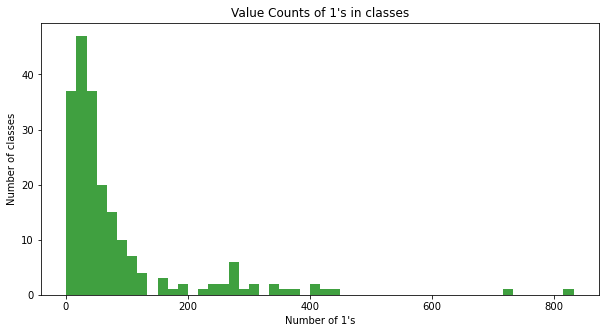

In [93]:
### Plot histogram of 1s counts in classes 

matplotlib.rcParams['figure.figsize'] = [10, 5]

plt.hist(value_counts_arr, 50, facecolor='g', alpha=0.75)
plt.xlabel('Number of 1\'s')
plt.ylabel('Number of classes')
plt.title('Value Counts of 1\'s in classes')
plt.show()

As you can see, there is a significantly small amount of positive labels in many classes. Three classes only have one positive instance! We must make sure we have these instances in the training set and not the validation set, or else our model will only predict one class! This is why we have to use a stratified k-fold.

## Preparing our data

I decided to use One-Hot encoding for the categorical features. There are several other encoders to try that may perform better.  

In [117]:
### Dealing w/ categorical features


# Encode training categorical features
enc1 = ce.OneHotEncoder(cols=['cp_type', 'cp_dose','cp_time']).fit(train_features_df)
train_features_enc_df = enc1.transform(train_features_df)

# Encode testing categorical features
enc2 = ce.OneHotEncoder(cols=['cp_type', 'cp_dose','cp_time']).fit(test_features_df)
test_features_enc_df = enc2.transform(test_features_df)

/opt/conda/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/opt/conda/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [118]:
### Verify

#print(train_features_enc_df.head())
#print(train_features_enc_df.describe())

#print(test_features_enc_df.head())
#print(test_features_enc_df.describe())

         sig_id  cp_type_1  cp_type_2  cp_time_1  cp_time_2  cp_time_3  \
0  id_000644bb2          1          0          1          0          0   
1  id_000779bfc          1          0          0          1          0   
2  id_000a6266a          1          0          0          0          1   
3  id_0015fd391          1          0          0          0          1   
4  id_001626bd3          1          0          0          1          0   

   cp_dose_1  cp_dose_2     g-0     g-1  ...    c-90    c-91    c-92    c-93  \
0          1          0  1.0620  0.5577  ...  0.2862  0.2584  0.8076  0.5523   
1          1          0  0.0743  0.4087  ... -0.4265  0.7543  0.4708  0.0230   
2          1          0  0.6280  0.5817  ... -0.7250 -0.6297  0.6103  0.0223   
3          1          0 -0.5138 -0.2491  ... -2.0990 -0.6441 -5.6300 -1.3780   
4          0          1 -0.3254 -0.4009  ...  0.0042  0.0048  0.6670  1.0690   

     c-94    c-95    c-96    c-97    c-98    c-99  
0 -0.1912  0.6584 -0.3

In [96]:
### Initialize stratified k-fold object

skf = MultilabelStratifiedKFold(n_splits = FOLDS,random_state=SEED,shuffle=True)

In [119]:
### Rename dataframes and drop 'id' columns

X = train_features_enc_df.drop(columns=['sig_id'])
X_test = test_features_enc_df.drop(columns=['sig_id'])
y = train_targets_df.drop(columns=['sig_id'])

## Ensemble setup

My neural network contains 3 hidden layers, with batch normalization and dropout. This architecture is very simple (trains in only a few seconds w/ GPU) and should be experimented with to see what works best. Be sure to keep the last layer's activation as 'sigmoid' so that the outputs are all in [0,1].

In [98]:
def get_tf_model():
    model = tf.keras.Sequential([
        L.Flatten(input_shape=(1,879)),
        L.Dense(2000, activation='relu'),
        L.BatchNormalization(),
        L.Dropout(.4),
        L.Dense(1000, activation='relu'),
        L.BatchNormalization(),
        L.Dropout(.4),
        L.Dense(1000, activation='relu'),
        L.BatchNormalization(),
        L.Dropout(.4),
        L.Dense(206, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss = 'binary_crossentropy',
        metrics=['accuracy']
    )
    
    model.summary()
    
    return model

This type of learning rate schedule has become the go-to for Kaggle competitions. It starts out small, ramps up to a certain threshold for a couple epochs, then decays exponentially.

In [99]:
### learning rate schedule

def lrfn(epoch):
    
    if epoch < lr_rampup_epochs:
        lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
    elif epoch < lr_rampup_epochs + lr_sustain_epochs:
        lr = lr_max
    else:
        lr = (lr_max - lr_min) * lr_exp_decay**(epoch - lr_rampup_epochs - lr_sustain_epochs) + lr_min
    return lr

In [100]:
def plot_lr():
    rng = [i for i in range(EPOCHS)]
    y = [lrfn(x) for x in rng]
    plt.plot(rng, y)
    print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [101]:
### Fit model

def fit_model(model,X_train,X_valid,y_train,y_valid):

    start = time.time()
    
    print('Beginning to fit ',type(model))

    if 'tensorflow' in str(type(model)): # Fit neural net model
    
        model.fit(
            X_train,
            y_train,
            epochs=EPOCHS,
            verbose=1,
            batch_size=BATCH_SIZE,
            callbacks=[lr_schedule],
            validation_data=(X_valid,y_valid)
        )
    
    else: # Fit other type of model
    
        model.fit(X_train,y_train)

    print('Total time taken to fit model: ', time.time() - start, ' seconds')

In [102]:
### Make Predictions

def get_preds(model,X_valid,final=False):

    if 'tensorflow' in str(type(model)): # Neural Network model predictions 
        
        if final==True:
            preds = np.array(model.predict(X_test).astype("float64"))
        else:
            preds = np.array(model.predict(X_valid).astype("float64"))
            
    else:    # Other model predictions          
        
        if final==True:
            preds = np.array(model.predict_proba(X_test))
        else:
            preds = np.array(model.predict_proba(X_valid))
        
        preds = preds[:,:,1].T
    
    return preds

In [103]:
### Calculate validation score

def calc_loss(vals,preds):

    score = log_loss(np.ravel(vals),np.ravel(preds))
    
    cv_scores.append(score)

    print('Validation log loss score: {}'.format(score))

In [104]:
def run_model(model,X_train,X_valid,y_train,y_valid):

    ### fit the model
    fit_model(model,X_train,X_valid,y_train,y_valid)

    print('Getting validation predictions...')
    
    ### get the predictions
    temp_val_preds = get_preds(model,X_valid,final=False)
    
    ### calculate log loss
    calc_loss(y_valid,temp_val_preds)
    
    print('Calculating final predictions...')

    ### final preds
    final_preds.append(get_preds(model,X_valid,final=True))
    
    print('Done')

In [19]:
### XGBoost Model

if include_xgboost == True:
    
    model_1 = MultiOutputClassifier(XGBClassifier(tree_method='gpu_hist'))

    # The MultiOutputClassifier wrapper creates one model for each class (i.e. 206 different models total)

    # Using parameters from https://www.kaggle.com/fchmiel/xgboost-baseline-multilabel-classification
    params = {'estimator__colsample_bytree': 0.6522,
          'estimator__gamma': 3.6975,
          'estimator__learning_rate': 0.0503,
          'estimator__max_delta_step': 2.0706,
          'estimator__max_depth': 10,
          'estimator__min_child_weight': 31.5800,
          'estimator__n_estimators': 166,
          'estimator__subsample': 0.8639
         }

    model_1.set_params(**params)

In [120]:
### Neural Network Model

if include_neural_net == True:
    
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)
    
    plot_lr()
    
    model_2 = get_tf_model()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 879)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 2000)              1760000   
_________________________________________________________________
batch_normalization_9 (Batch (None, 2000)              8000      
_________________________________________________________________
dropout_9 (Dropout)          (None, 2000)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 1000)              2001000   
_________________________________________________________________
batch_normalization_10 (Batc (None, 1000)              4000      
_________________________________________________________________
dropout_10 (Dropout)         (None, 1000)             

In [21]:
### Logistic Regression model

if include_logreg == True:
    
    model_3 = MultiOutputClassifier(LogisticRegression(max_iter=10000, tol=0.1, C = 0.5,verbose=0,random_state = SEED))

## Train models

In [121]:
cv_scores = []
final_preds = []

Beginning fold 1
TRAIN INDEX: [    0     2     3 ... 23811 23812 23813] VALID INDEX: [    1     5     8 ... 23803 23809 23810]
X_train    cp_type_1  cp_type_2  cp_time_1  cp_time_2  cp_time_3  cp_dose_1  \
0          1          0          1          0          0          1   
2          1          0          0          0          1          1   
3          1          0          0          0          1          1   
4          1          0          0          1          0          0   
6          1          0          1          0          0          0   

   cp_dose_2     g-0     g-1     g-2  ...    c-90    c-91    c-92    c-93  \
0          0  1.0620  0.5577 -0.2479  ...  0.2862  0.2584  0.8076  0.5523   
2          0  0.6280  0.5817  1.5540  ... -0.7250 -0.6297  0.6103  0.0223   
3          0 -0.5138 -0.2491 -0.2656  ... -2.0990 -0.6441 -5.6300 -1.3780   
4          1 -0.3254 -0.4009  0.9700  ...  0.0042  0.0048  0.6670  1.0690   
6          1  2.0440  1.7000 -1.5390  ...  0.1855  1.


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 1/20
140/140 [==============================] - 9s 61ms/step - loss: 0.8338 - accuracy: 0.0084 - val_loss: 0.6692 - val_accuracy: 0.0131

Epoch 00002: LearningRateScheduler reducing learning rate to 0.00014.
Epoch 2/20
140/140 [==============================] - 8s 58ms/step - loss: 0.6927 - accuracy: 0.0171 - val_loss: 0.5499 - val_accuracy: 0.0202

Epoch 00003: LearningRateScheduler reducing learning rate to 0.00017999999999999998.
Epoch 3/20
140/140 [==============================] - 8s 59ms/step - loss: 0.4503 - accuracy: 0.0219 - val_loss: 0.2571 - val_accuracy: 0.0220

Epoch 00004: LearningRateScheduler reducing learning rate to 0.00021999999999999998.
Epoch 4/20
140/140 [==============================] - 9s 61ms/step - loss: 0.1692 - accuracy: 0.0214 - val_loss: 0.0850 - val_accuracy: 0.0336

Epoch 00005: LearningRateScheduler reducing learning rate to 0.00026.
Epoch 5/20
140/140 [========================


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 1/20
140/140 [==============================] - 9s 62ms/step - loss: 0.0197 - accuracy: 0.0811 - val_loss: 0.0187 - val_accuracy: 0.0846

Epoch 00002: LearningRateScheduler reducing learning rate to 0.00014.
Epoch 2/20
140/140 [==============================] - 8s 58ms/step - loss: 0.0193 - accuracy: 0.0870 - val_loss: 0.0183 - val_accuracy: 0.1110

Epoch 00003: LearningRateScheduler reducing learning rate to 0.00017999999999999998.
Epoch 3/20
140/140 [==============================] - 8s 58ms/step - loss: 0.0190 - accuracy: 0.0904 - val_loss: 0.0180 - val_accuracy: 0.1132

Epoch 00004: LearningRateScheduler reducing learning rate to 0.00021999999999999998.
Epoch 4/20
140/140 [==============================] - 8s 58ms/step - loss: 0.0184 - accuracy: 0.0951 - val_loss: 0.0175 - val_accuracy: 0.0900

Epoch 00005: LearningRateScheduler reducing learning rate to 0.00026.
Epoch 5/20
140/140 [========================


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 1/20
140/140 [==============================] - 9s 64ms/step - loss: 0.0158 - accuracy: 0.1318 - val_loss: 0.0142 - val_accuracy: 0.1515

Epoch 00002: LearningRateScheduler reducing learning rate to 0.00014.
Epoch 2/20
140/140 [==============================] - 9s 61ms/step - loss: 0.0156 - accuracy: 0.1361 - val_loss: 0.0142 - val_accuracy: 0.1503

Epoch 00003: LearningRateScheduler reducing learning rate to 0.00017999999999999998.
Epoch 3/20
140/140 [==============================] - 8s 60ms/step - loss: 0.0153 - accuracy: 0.1456 - val_loss: 0.0143 - val_accuracy: 0.1556

Epoch 00004: LearningRateScheduler reducing learning rate to 0.00021999999999999998.
Epoch 4/20
140/140 [==============================] - 8s 58ms/step - loss: 0.0151 - accuracy: 0.1470 - val_loss: 0.0143 - val_accuracy: 0.1480

Epoch 00005: LearningRateScheduler reducing learning rate to 0.00026.
Epoch 5/20
140/140 [========================


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 1/20
140/140 [==============================] - 8s 59ms/step - loss: 0.0117 - accuracy: 0.2591 - val_loss: 0.0070 - val_accuracy: 0.3939

Epoch 00002: LearningRateScheduler reducing learning rate to 0.00014.
Epoch 2/20
140/140 [==============================] - 8s 59ms/step - loss: 0.0113 - accuracy: 0.2639 - val_loss: 0.0074 - val_accuracy: 0.3800

Epoch 00003: LearningRateScheduler reducing learning rate to 0.00017999999999999998.
Epoch 3/20
140/140 [==============================] - 9s 61ms/step - loss: 0.0109 - accuracy: 0.2752 - val_loss: 0.0077 - val_accuracy: 0.3674

Epoch 00004: LearningRateScheduler reducing learning rate to 0.00021999999999999998.
Epoch 4/20
140/140 [==============================] - 8s 59ms/step - loss: 0.0105 - accuracy: 0.2871 - val_loss: 0.0080 - val_accuracy: 0.3622

Epoch 00005: LearningRateScheduler reducing learning rate to 0.00026.
Epoch 5/20
140/140 [========================

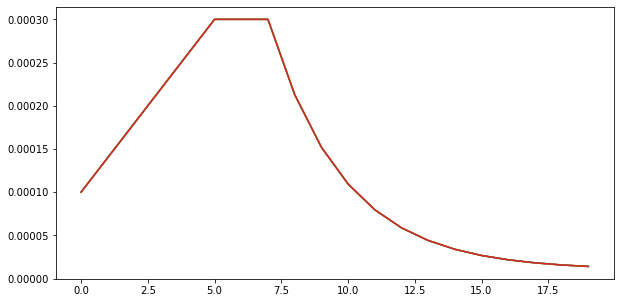

In [122]:
### Stratified K-Fold loop 

for fold, (train_index, valid_index) in enumerate(skf.split(X, y)):
    
    print('Beginning fold',fold+1)
    print("TRAIN INDEX:", train_index, "VALID INDEX:", valid_index)
    
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    if include_xgboost == True:
        
        run_model(model_1,X_train,X_valid,y_train,y_valid) # takes ~4 minutes
        
    if include_neural_net == True:
        
        run_model(model_2,X_train,X_valid,y_train,y_valid) # takes ~10 seconds with GPU
        
    if include_logreg == True:
        
        run_model(model_3,X_train,X_valid,y_train,y_valid) # takes ~8 min
        


In [ ]:
### Show all CV scores

print('Cross Validation scores: ',cv_scores)

In [132]:
### Ensemble final predictions

print('Ensembling final predictions')
final_predictions = np.mean(np.array(final_preds),axis=0)

print('Done')

Ensembling final predictions
Done


## Output results

In [30]:
### Output final predictions

sample_sub_df.iloc[:,1:] = final_predictions
sample_sub_df.to_csv('submission.csv',index=False)

In [31]:
### Insight into final predictions

sample_sub_df.describe()

,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
count,3982.000000,3982.000000,3982.000000,3.982000e+03,3.982000e+03,3.982000e+03,3.982000e+03,3.982000e+03,3982.000000,3.982000e+03,...,3982.000000,3982.000000,3982.000000,3982.000000,3.982000e+03,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000
mean,0.000370,0.000328,0.000484,7.120143e-03,1.046316e-02,1.798287e-03,1.119509e-03,2.407543e-03,0.000171,1.240592e-02,...,0.000136,0.000414,0.000785,0.011926,2.007071e-03,0.000150,0.005570,0.000393,0.001431,0.000522
std,0.004141,0.002580,0.005056,3.098040e-02,2.679376e-02,1.196302e-02,5.672261e-03,1.405394e-02,0.000132,3.728027e-02,...,0.000175,0.005480,0.002849,0.092728,1.130211e-02,0.000101,0.039146,0.000746,0.020371,0.002465
min,0.000002,0.000003,0.000001,9.170964e-07,8.501720e-07,9.982148e-07,8.135466e-07,4.057433e-07,0.000008,2.552764e-07,...,0.000006,0.000002,0.000001,0.000002,6.148182e-07,0.000004,0.000002,0.000001,0.000001,0.000002
25%,0.000111,0.000123,0.000204,1.002858e-03,1.911399e-03,4.401475e-04,5.039043e-04,6.328827e-04,0.000097,1.885073e-03,...,0.000081,0.000103,0.000363,0.000169,2.507711e-04,0.000086,0.000118,0.000209,0.000276,0.000268
50%,0.000211,0.000233,0.000318,1.927934e-03,5.034471e-03,9.160799e-04,8.358637e-04,1.217232e-03,0.000158,4.782439e-03,...,0.000121,0.000200,0.000565,0.000422,5.794931e-04,0.000138,0.000339,0.000329,0.000494,0.000421
75%,0.000327,0.000345,0.000449,3.171309e-03,8.548996e-03,1.351897e-03,1.148176e-03,1.844543e-03,0.000229,8.615820e-03,...,0.000169,0.000366,0.000811,0.001036,1.315991e-03,0.000198,0.001118,0.000461,0.000754,0.000572
max,0.210134,0.125887,0.282515,3.382726e-01,3.290400e-01,2.700277e-01,2.440673e-01,3.350974e-01,0.004719,3.878667e-01,...,0.007840,0.338085,0.139170,0.995495,3.323653e-01,0.002651,0.965009,0.032504,0.665003,0.129687
